## Requirement

In [ ]:
!pip install causalml
!pip install linearmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 833.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.6 MB/s eta 0:00:00


In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [8]:
data_url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
df_origin = pd.read_csv(data_url)
df_origin = df_origin.drop(columns=['rownames'])
df_origin.head()

,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
0,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
1,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
2,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other


In [9]:
df = df_origin.copy()

[종속변수 (Y)]

*   education: 최종 학력 (교육 연수)

[핵심 설명변수 및 도구변수 (X, Z)]  

*   distance: 거주지에서 가장 가까운 4년제 대학까지의 거리 (10마일 단위)
*   tuition: 주(state)의 평균 4년제 대학 등록금 (1000달러 단위)
*   지역경제
	- wage: 임금 (시간당)
	-	unemp: 1980년 기준 거주 카운티의 실업률


---
[통제변수 (개인 단위)]

일반적으로 인구통계학적, 능력적 변수를 통제변수로 사용.

* gender: 성별 (예: female, male)
* ethnicity: 인종 (예: afam, hisp, other)
* score: 고등학교 재학 중 치른 종합 시험 점수
* fcollege: 아버지가 대학 졸업자인지 여부 (factor)
* mcollege: 어머니가 대학 졸업자인지 여부 (factor)
* home: 자가 거주 여부 (factor)
* urban: 학교가 도시에 위치하는지 여부 (factor)
* income: 가구 소득이 $25,000를 초과하는지 여부 (factor)
* region: 거주 지역 (예: west, other)



---
[출처]
* https://www.princeton.edu/~mwatson/Stock-Watson_3u/Students/EE_Datasets/CollegeDistance_DataDescription.pdf

## EDA

**당시에 미국에서 직면했던 문제:**

Community College(2년제 대학)가 빠르게 확산되면서
교육 기회의 민주화 효과 (democratization)와 최종 교육수준이 낮아지는 분산 효과 (diversion)
중 무엇이 더 큰지에 대한 논란이 생김.

**이에 따라 나온 것이 해당 논문:**

“Democratization or Diversion? The Effect of Community
Colleges on Educational Attainment"

**논문의 핵심질문:**

-> "Community college의 접근성이 확대되면 개인의 교육 성취도(educational attainment)가 증가하는가, 아니면 오히려 4년제 대학 진학을 방해해 평균 교육수준을 낮추는가?"

### Q0. 종속변수 확인

In [10]:
df['education'].value_counts()

# 종속변수 (Y): 교육 연한
## 고등학교만 졸업하면 12년
## 전문대(AA)까지 하면 14년
## 4년제 학사(BA)까지 하면 16년
## 대학원 교육은 17–18년으로 코딩

,count
education,
12,1832
16,907
13,613
15,556
14,518
17,256
18,57


### Q1. 핵심변수 (X ~ Y) 관계 확인

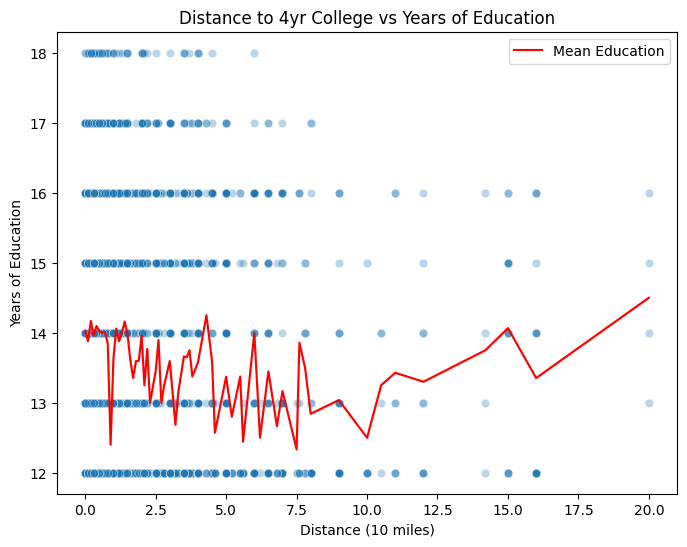

In [11]:
# Q1-1. 거리(dist)와 교육 연한(education)의 관계: 4년제 대학에 거리가 가까울수록 교육 수준이 높은가?

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="distance", y="education", alpha=0.3)
sns.lineplot(
    x=df["distance"],
    y=df.groupby("distance")["education"].transform("mean"),
    color="red", label="Mean Education"
)
plt.title("Distance to 4yr College vs Years of Education")
plt.xlabel("Distance (10 miles)")
plt.ylabel("Years of Education")
plt.legend()
plt.show()

# 거리(distance)와 교육연한(education)의 산점도는 매우 불규칙.
# 아래의 그림에서는 그룹을 묶어서 살펴볼 예정.

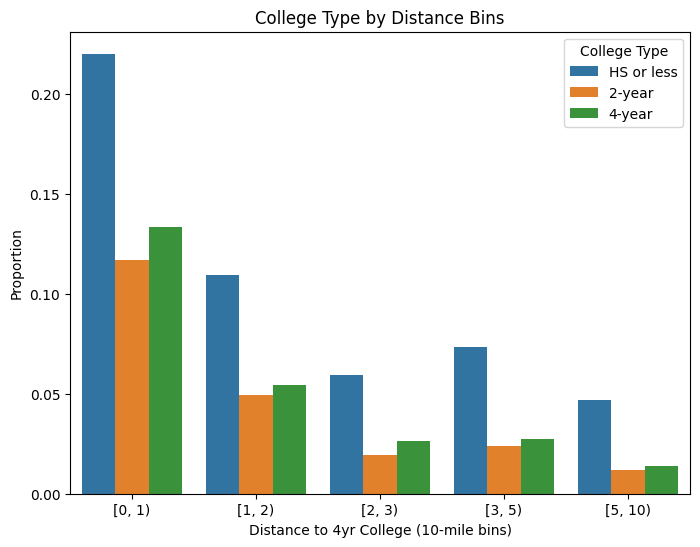

In [12]:
# Q1-2. 거리별 4년제 vs 2년제 vs 고등학교 이하 진학 비율에 차이가 있는가?

df["college_type"] = np.where(df["education"] >= 16, "4-year",
                        np.where(df["education"] >= 14, "2-year", "HS or less"))

df["distance_bin"] = pd.cut(df["distance"], bins=[0,1,2,3,5,10], right=False)

plt.figure(figsize=(8,6))
sns.countplot(data=df, x="distance_bin", hue="college_type", stat="proportion")
plt.title("College Type by Distance Bins")
plt.xlabel("Distance to 4yr College (10-mile bins)")
plt.ylabel("Proportion")
plt.legend(title="College Type")
plt.show()

# 거리가 멀어질수록 4년제(초록)와 2년제(주황) 비율이 뚜렷하게 감소.

### Q2. 통제변수 factor 확인

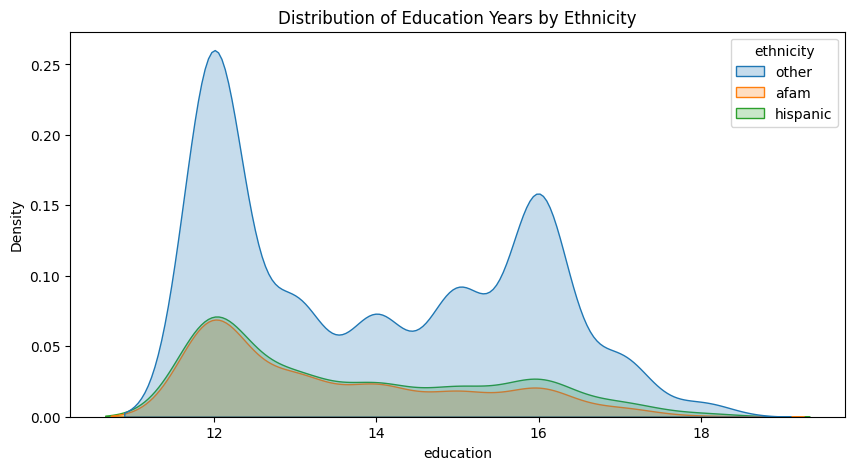

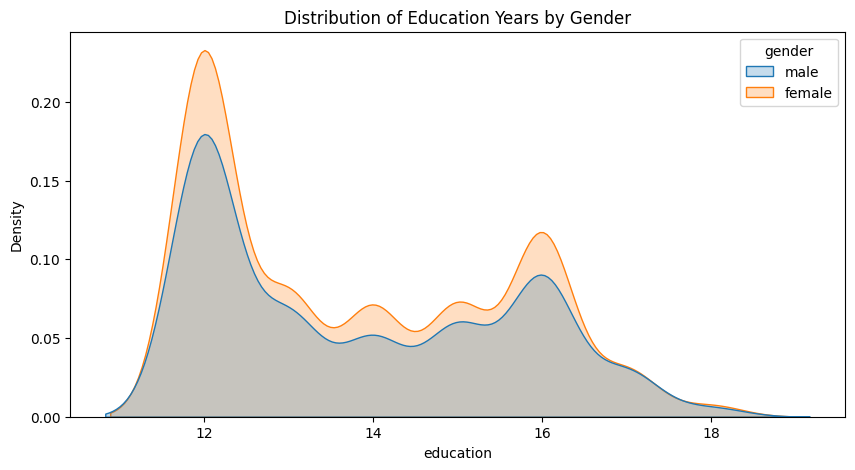

In [18]:
# Q2-1. 인구학적 배경(인종·성별)에 따른 교육연한 분포에 차이가 있는가?
plt.figure(figsize=(10,5))
sns.kdeplot(data=df[df["ethnicity"].isin(["afam","hispanic", "other"])], x="education", hue="ethnicity", fill=True)
plt.title("Distribution of Education Years by Ethnicity")
plt.show()

plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x="education", hue="gender", fill=True)
plt.title("Distribution of Education Years by Gender")
plt.show()


### 결론: 사회적 배경에 따른 교육연한 분포 차이가 크기 때문에 통제변수로 사용해야한다.
## 1. 인종에 따른 교육 격차 존재 -> 즉 통제필요.
# 흑인(afam)과 히스패닉(hispanic) 학생들은 고등교육(특히 4년제 학사 이상)에 진입하는 비율이 낮고, 고졸 수준에서 멈추는 비중이 높음.
# 반대로 “other” 집단은 4년제 대학까지 진학하는 경우가 비교적 많음.

## 2. 다만, 성별에 따른 차이는 비교적 크지 않은 것으로 보임.

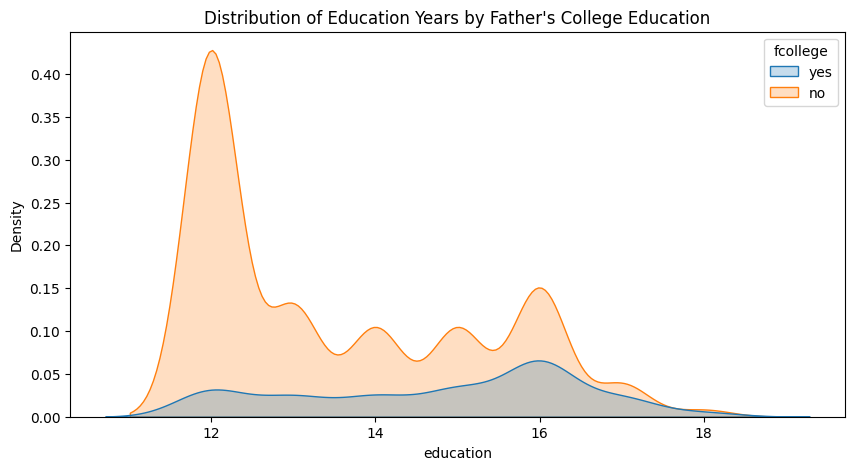

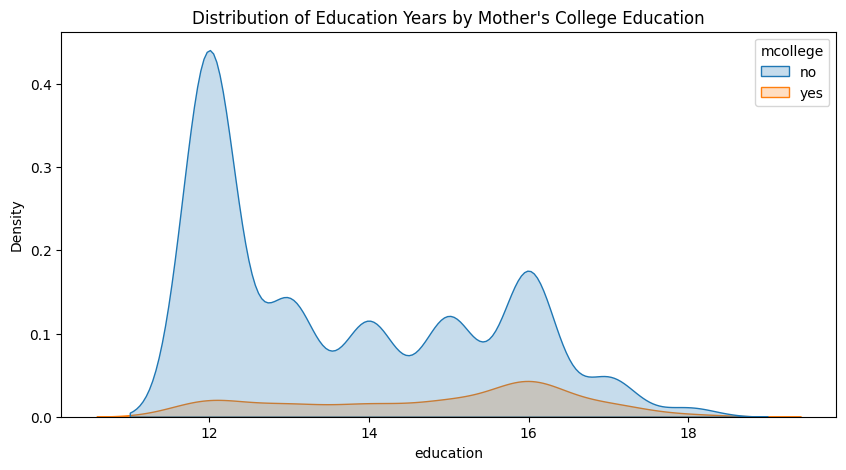

In [17]:
## Q2-2. 부모의 배경에 따른 교육연한 분포에 차이가 있는가?

plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x="education", hue="fcollege", fill=True)
plt.title("Distribution of Education Years by Father's College Education")
plt.show()

plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x="education", hue="mcollege", fill=True)
plt.title("Distribution of Education Years by Mother's College Education")
plt.show()

### 결론: 부모의 배경에 따른 교육연한 분포 차이가 매우 크기 때문에 통제변수로 사용해야한다.

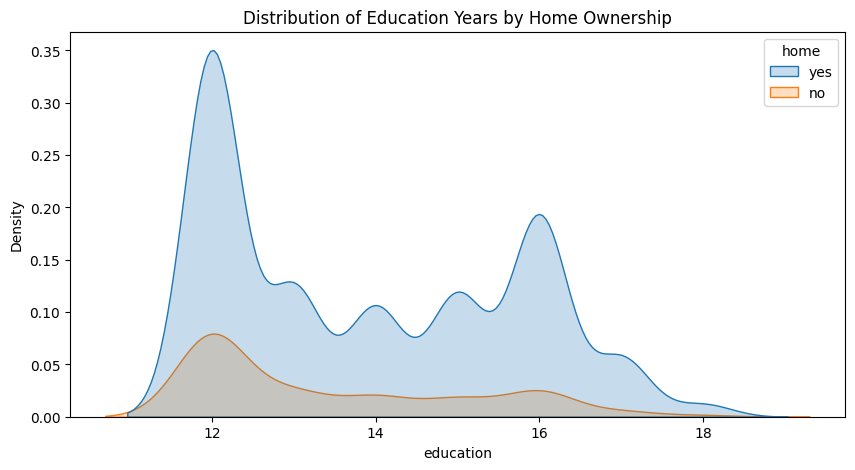

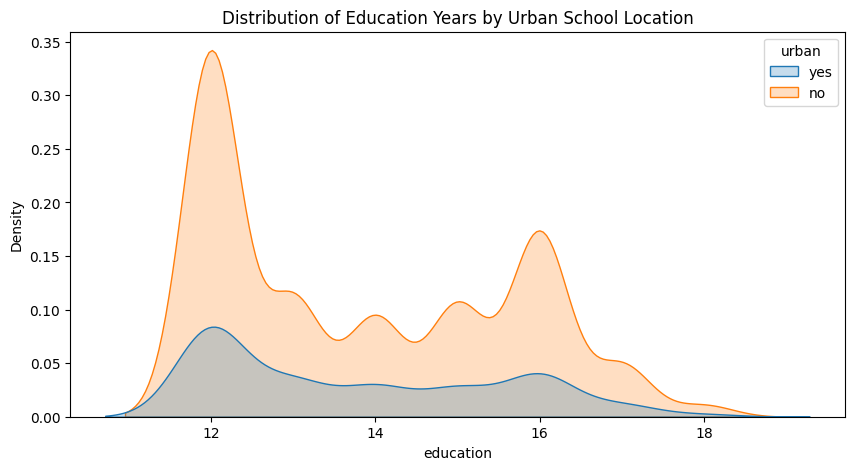

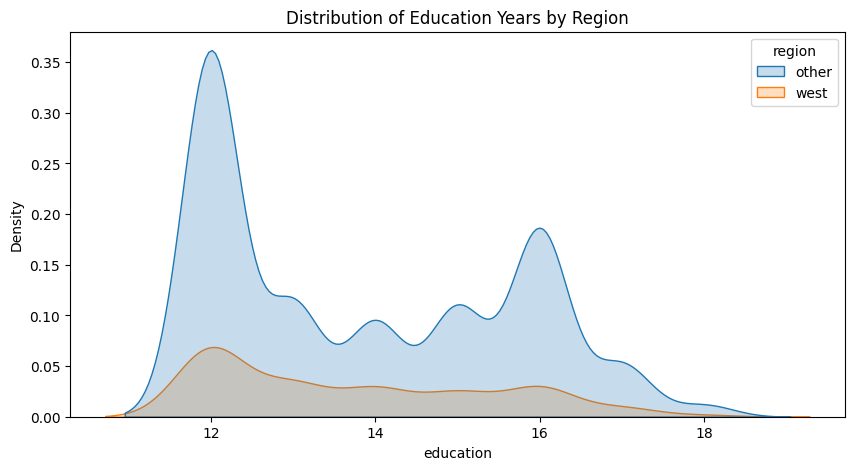

In [19]:
# Q2-3. 지역 배경에 따른 교육연한 분포에 차이가 있는가?
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x="education", hue="home", fill=True)
plt.title("Distribution of Education Years by Home Ownership")
plt.show()

plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x="education", hue="urban", fill=True)
plt.title("Distribution of Education Years by Urban School Location")
plt.show()

plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x="education", hue="region", fill=True)
plt.title("Distribution of Education Years by Region")
plt.show()

## 지역 배경에 따른 교육연한 분포에 차이가 크기 때문에 통제가 필요할 것으로 보임.

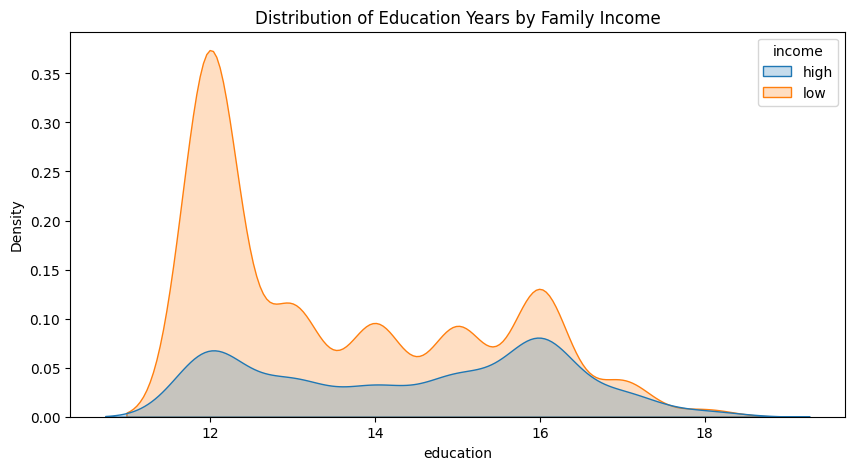

In [20]:
# Q2-4. 소득 정도에 따른 교육연한 분포에 차이가 있는가?
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x="education", hue="income", fill=True)
plt.title("Distribution of Education Years by Family Income")
plt.show()

## 소득 정도에 따른 교육연한 분포에 차이가 크기 때문에 통제가 필요할 것으로 보임.

### Q3. 변수간 상관관계 체크

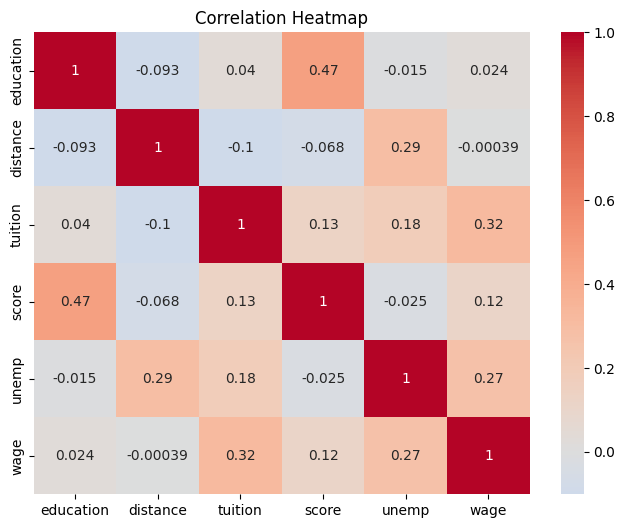

In [21]:
# Q3. 주요변수간 상관관계

corr_vars = ["education","distance","tuition","score","unemp","wage"]
corr = df[corr_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

# score -> education이 가장 강한 개인적 결정 요인.
# distance, unemp, wage, tuition은 지역적 요인으로 서로 상관관계가 높은 편.
# distance와 education은 (산점도에서 본 것처럼) 단순 상관이 약함.

### DAG

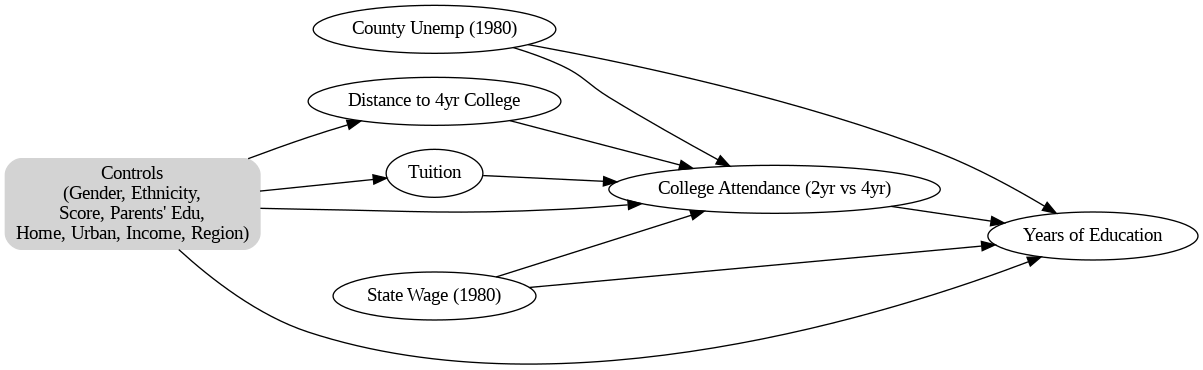![](/content/college_distance_dag.png)

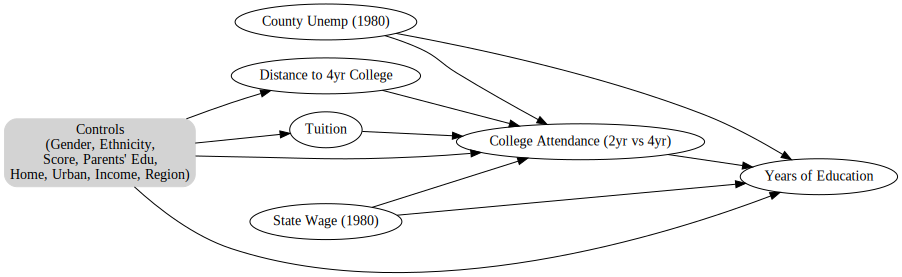

In [26]:
from graphviz import Digraph
from IPython.display import display

dot = Digraph(comment="College Distance DAG", graph_attr={"rankdir":"LR"})  # 좌→우 방향으로 배치

# 주요 노드
dot.node("Dist", "Distance to 4yr College")
dot.node("Tuition", "Tuition")
dot.node("Unemp", "County Unemp (1980)")
dot.node("Wage", "State Wage (1980)")
dot.node("Attend", "College Attendance (2yr vs 4yr)")
dot.node("Edu", "Years of Education")

# Controls (묶음 처리)
dot.node("Controls", "Controls\n(Gender, Ethnicity,\nScore, Parents' Edu,\nHome, Urban, Income, Region)",
         shape="box", style="rounded,filled", color="lightgrey")

# 주요 경로
dot.edge("Dist", "Attend")
dot.edge("Tuition", "Attend")
dot.edge("Attend", "Edu")

# Controls에서 Attend/Edu로 가는 화살표
dot.edge("Controls", "Attend")
dot.edge("Controls", "Edu")

# 지역 경제 변수
dot.edge("Unemp", "Attend")
dot.edge("Wage", "Attend")
dot.edge("Unemp", "Edu")
dot.edge("Wage", "Edu")

# Region → Dist, Tuition
dot.edge("Controls", "Tuition")
dot.edge("Controls", "Dist")

display(dot)

## IV로 적합한지 검증하기

현재 Attendance는 학생의 능력·가정 배경 등과 얽혀 있어 내생성(endogeneity) 문제가 발생.
내생성을 통제하기 위해 도구변수 (IV)를 찾아야함.

IV는 두 가지를 만족해야함:
* **관련성 (Relevance)**: IV가 Attendance에 영향을 줘야 한다.
* **외생성 (Exogeneity)**: IV가 Education에 직접적으로는 영향을 주지 않고, 오직 Attendance를 통해서만 Education에 영향을 줘야 한다.

여기서 도구변수 후보는 2가지 (tuition, distance).  
따라서 핵심 인과 구조는 다음과 같이 표현할 수 있다:

$$
\text{Distance} \;\;\rightarrow\;\; \text{Attendance} \;\;\rightarrow\;\; \text{Education}
$$

$$
\text{Tuition} \;\;\rightarrow\;\; \text{Attendance} \;\;\rightarrow\;\; \text{Education}
$$


In [39]:
# 1. Distance가 IV로 적합한가?

# 조건1. Relevance

# Attendance 정의: 4년제 대학 이상 진학 여부 (중도퇴학 포함)
df["attend4yr"] = df["education"].isin([15,16,17,18]).astype(int)

# 1단계 회귀: Attendance ~ Distance (+ Controls)
first_stage = smf.ols(
    "attend4yr ~ distance + score + C(gender) + C(ethnicity) + C(income) "
    "+ C(fcollege) + C(mcollege) + C(home) + C(urban) + C(region)",
    data=df
).fit()


print(first_stage.summary())

# 조건2. Exogeneity
## IV가 Education에 직접적으로 영향을 주지 않음은 산점도와 상관관계 분석으로 드러남.
## Distance: 개인 능력·부모학력과 무관하며 단지 물리적 접근성만 반영 -> exogenous 가능성이 크다.

# relevance(관련성) 측면에서 설명력이 약한 것으로 보이기 때문에, tuituon까지 보조 도구변수로 사용.

                            OLS Regression Results                            
Dep. Variable:              attend4yr   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     123.2
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          7.15e-249
Time:                        08:31:33   Log-Likelihood:                -2688.9
No. Observations:                4739   AIC:                             5402.
Df Residuals:                    4727   BIC:                             5479.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [40]:
# 2. Distance & Tuition이 IV로 적합한가?

# 조건1. Relevance

# 1단계 회귀: Attendance ~ Distance + Tuition (+ Controls)
first_stage = smf.ols(
    "attend4yr ~ distance + tuition + score + C(gender) + C(ethnicity) + C(income) "
    "+ C(fcollege) + C(mcollege) + C(home) + C(urban) + C(region)",
    data=df
).fit()

print(first_stage.summary())

# 조건2. Exogeneity
## IV가 Education에 직접적으로 영향을 주지 않음은 산점도와 상관관계 분석으로 드러남.
## Tuition: 주별 재정·정책 요인으로 결정되며, 개별 학생 특성과 독립적 -> exogenous 할 수 있음.

# relevance(관련성) 측면에서 여전히 설명력이 약함 (weak IV).

                            OLS Regression Results                            
Dep. Variable:              attend4yr   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     113.2
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          2.06e-248
Time:                        08:31:34   Log-Likelihood:                -2687.5
No. Observations:                4739   AIC:                             5401.
Df Residuals:                    4726   BIC:                             5485.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [46]:
# 3. attendance 정의를 바꾼다면?
# 기존 시각화에서 아이디어를 얻어, 이진분류가 아닌 다중분류로 정의한다면?
# HS / 2년제 / 4년제로 분류.

## 1. Relevance 체크

# 카테고리 정의
df["college_type"] = pd.cut(
    df["education"],
    bins=[0, 12, 14, 18],
    labels=["HS_or_less", "2yr", "4yr_plus"],
    right=True
)

y = df["college_type"].astype("category").cat.codes

# 독립변수 dummy 처리
X = df[["distance","tuition","score","gender","ethnicity","income",
        "fcollege","mcollege","home","urban","region"]]
X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)
X = sm.add_constant(X)

# Multinomial logit
mnl_model = sm.MNLogit(y, X).fit()
print(mnl_model.summary())

# Distance는 4년제 진학에 특히 부정적 영향 -> IV relevance 신호 존재.
# Tuition 역시 attend 여부에 영향을 줌 → 보조 IV로 plausibly relevance 있음.

Optimization terminated successfully.
         Current function value: 0.920548
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 4739
Model:                        MNLogit   Df Residuals:                     4713
Method:                           MLE   Df Model:                           24
Date:                Sun, 31 Aug 2025   Pseudo R-squ.:                  0.1454
Time:                        08:36:17   Log-Likelihood:                -4362.5
converged:                       True   LL-Null:                       -5104.7
Covariance Type:            nonrobust   LLR p-value:                4.548e-299
               y=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.9403      0.306     -9.621      0.000      -3.539      -2.341
dista

## Confounder로 적합한지 검증하기

노동시장 상황이 college attendance에 영향을 준다는 건 경제학적으로 강력한 근거가 존재.

그러면서 개인의 능력·가정배경과 무관한 지역 노동시장 요인으로 backdoor path를 만듦.
* 실업률이 오르면 대학에 오래 남음 (opportunity cost 낮음)
* 임금이 오르면 고졸 취업 유인 증가 (attendance 감소)
* 동시에 최종 education에도 직접 영향 (학교 선택 및 지속 여부)

$$
\text{Attendance} \;\;\leftarrow\;\; \text{Unemp} \;\;\rightarrow\;\; \text{Education}
$$

$$
\text{Attendance} \;\;\leftarrow\;\; \text{Wage} \;\;\rightarrow\;\; \text{Education}
$$

In [49]:
## college_type ~ unemp + wage + controls 체크

y = df["college_type"].astype("category").cat.codes
X = df[["unemp","wage","score","gender","ethnicity","income",
        "fcollege","mcollege","home","urban","region"]]
X = pd.get_dummies(X, drop_first=True)
X = sm.add_constant(X)
X = X.astype(float)

mnl = sm.MNLogit(y, X).fit()
print(mnl.summary())

# 실업률은 2년제 진학 선택에 긍정적 신호, 임금은 약함.
# 실업률 오르면 대학에 더 오래 머무르는 경향, 임금 오르면 고졸로 노동시장 진입 유인 강해져서 대학 진학 odds 낮아짐.

Optimization terminated successfully.
         Current function value: 0.920879
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 4739
Model:                        MNLogit   Df Residuals:                     4713
Method:                           MLE   Df Model:                           24
Date:                Sun, 31 Aug 2025   Pseudo R-squ.:                  0.1451
Time:                        08:45:10   Log-Likelihood:                -4364.0
converged:                       True   LL-Null:                       -5104.7
Covariance Type:            nonrobust   LLR p-value:                2.130e-298
               y=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.2801      0.384     -8.547      0.000      -4.032      -2.528
unemp

In [50]:
## education ~ unemp + wage + controls 체크

ols = sm.OLS(df["education"], X).fit()
print(ols.summary())

# unemp + wage 모두 유의.

                            OLS Regression Results                            
Dep. Variable:              education   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     146.2
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          1.13e-312
Time:                        08:45:56   Log-Likelihood:                -8732.7
No. Observations:                4739   AIC:                         1.749e+04
Df Residuals:                    4726   BIC:                         1.758e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.7468      0

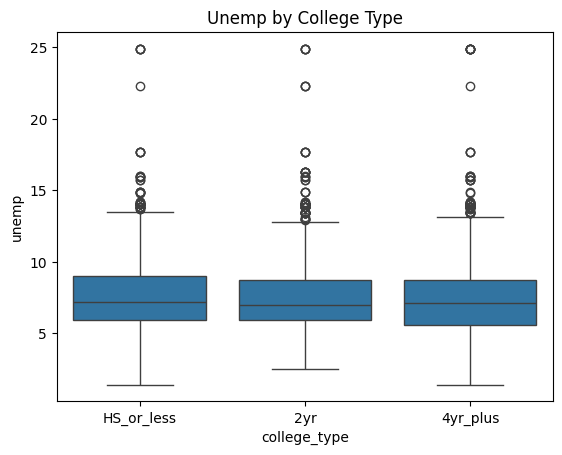

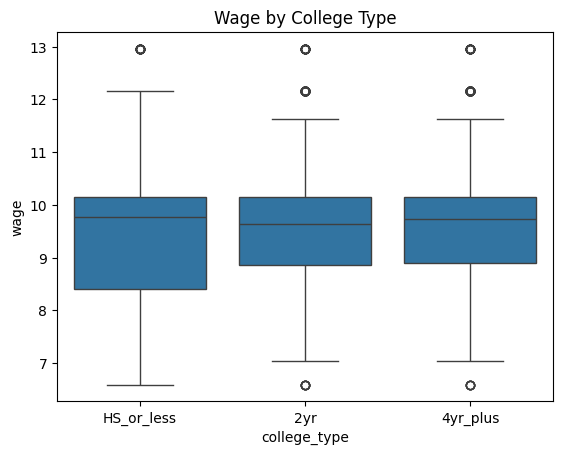

In [51]:
sns.boxplot(x="college_type", y="unemp", data=df)
plt.title("Unemp by College Type")
plt.show()

sns.boxplot(x="college_type", y="wage", data=df)
plt.title("Wage by College Type")
plt.show()

## 최종 코드

* 종속변수 (Y): education (최종 교육연한, 연속형)
* 내생변수 (D): attend4yr (4년제 이상 진학 여부, endogeneous regressor)
* 도구변수 (Z): distance, tuition
* 통제변수 (X): gender, ethnicity, income, fcollege, mcollege, home, urban, region, score, unemp, wage



---

[결과]
**(Case1, Case2) Community college 확산은 고졸 => 대학 진입 문턱을 낮추는 democratization 효과를 줬다.**

**(Case3) Community college 확산은 고졸 => 4년제 대학 진입 문턱을 낮추는 democratization 효과를 주지만, 2년제 진학만으로는 최종 교육연한을 늘린다고 보긴 어려움.**
 * 즉, 단순히 community college 확산만으로는 교육연한 증가를 보장하지 않음. 오히려 일부 학생이 4년제 대신 2년제를 택하면 diversion 효과가 발생할 수 있음.

In [61]:
## Case 0. OLS baseline

ols = smf.ols(
    "education ~ attend4yr + score + C(gender) + C(ethnicity) + C(income) "
    "+ C(fcollege) + C(mcollege) + C(home) + C(urban) + C(region) + unemp + wage",
    data=df
).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              education   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     889.9
Date:                Sun, 31 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:07:29   Log-Likelihood:                -6547.5
No. Observations:                4739   AIC:                         1.312e+04
Df Residuals:                    4725   BIC:                         1.321e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [62]:
## Case 1. distance, tuition 모두 IV

# 내생변수 정의: 4년제 이상 진학 여부
df["attend4yr"] = (df["education"] >= 16).astype(int)

# IV2SLS 회귀
iv_model1 = IV2SLS.from_formula(
    "education ~ 1 + score + C(gender) + C(ethnicity) + C(income) "
    "+ C(fcollege) + C(mcollege) + C(home) + C(urban) + C(region) "
    "+ unemp + wage " # confounder
    "[attend4yr ~ distance + tuition]", # 도구변수 지정
    data=df
).fit(cov_type="robust")

print(iv_model1.summary)

# 해석: IV 추정에 따르면, 4년제 대학 이상에 진학한 학생은 평균적으로 약 7.3년 더 교육을 받는다는 결과.
# 즉, 이는 community college로의 diversion 효과보다, 4년제 진학으로 이어지는 경우 교육연한 증가 효과가 압도적으로 크다는 걸 시사.

                          IV-2SLS Estimation Summary                          
Dep. Variable:              education   R-squared:                     -0.1868
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1900
No. Observations:                4739   F-statistic:                    1137.5
Date:                Sun, Aug 31 2025   P-value (F-stat)                0.0000
Time:                        09:07:29   Distribution:                 chi2(13)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    13.610     1.4759     9.2214     0.0000      10.717      16.

In [63]:
## Case 2. distance만 IV

from linearmodels.iv import IV2SLS

# 내생변수 정의: 4년제 이상 진학 여부
df["attend4yr"] = (df["education"] >= 16).astype(int)

# IV2SLS 회귀
iv_model2 = IV2SLS.from_formula(
    "education ~ 1 + score + C(gender) + C(ethnicity) + C(income) "
    "+ C(fcollege) + C(mcollege) + C(home) + C(urban) + C(region) "
    "+ unemp + wage " # confounder
    "[attend4yr ~ distance]", # 도구변수 지정
    data=df
).fit(cov_type="robust")

print(iv_model2.summary)

# 해석: IV 추정에 따르면, 4년제 대학 이상에 진학한 학생은 평균적으로 약 6.8년 더 교육을 받는다는 결과.
# 즉, 이는 community college로의 diversion 효과보다, 4년제 진학으로 이어지는 경우 교육연한 증가 효과가 압도적으로 크다는 걸 시사.

                          IV-2SLS Estimation Summary                          
Dep. Variable:              education   R-squared:                     -0.0023
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0050
No. Observations:                4739   F-statistic:                    1342.7
Date:                Sun, Aug 31 2025   P-value (F-stat)                0.0000
Time:                        09:07:30   Distribution:                 chi2(13)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    13.363     1.3706     9.7494     0.0000      10.676      16.

In [64]:
# Case 3. distance, tuition 모두 IV & 다항로짓
from linearmodels.iv import IV2SLS

# 더미 처리
df["attend_2yr"] = (df["college_type"] == "2yr").astype(int)
df["attend_4yr"] = (df["college_type"] == "4yr_plus").astype(int)

# IV2SLS (다중 endogenous)
iv_multi = IV2SLS.from_formula(
    "education ~ 1 + score + C(gender) + C(ethnicity) + C(income) "
    "+ C(fcollege) + C(mcollege) + C(home) + C(urban) + C(region) "
    "+ unemp + wage "
    "[attend_2yr + attend_4yr ~ distance + tuition]",
    data=df
).fit(cov_type="robust")

print(iv_multi.summary)

# 해석:	Democratization vs Diversion 논쟁
## HS->2yr 경로: 평균 교육연한 p-value 비유의적 → diversion 가능성
## HS->4yr 경로: 교육연한을 +4.6년 늘림 (p-value 유의) → democratization 효과
## 따라서, distance·tuition IV + 다항로짓으로 추정한 결과, 4년제 진학 효과가 압도적으로 크고 robust하다.

## Democratization 효과: 4년제 진학은 교육연한을 확실히 늘림 (+4.6년, p<0.01).
## Diversion 효과: 2년제 진학은 HS보다 길지만 (추정치 +1.2년), 유의하지 않아 “교육연한을 늘린다”는 결론을 강하게 내리긴 어려움.
## 즉,  4년제 진학은 교육연한을 확실히 늘리지만, 2년제 진학은 HS 대비 교육연한을 늘린다고 단정하기 어렵다.

                          IV-2SLS Estimation Summary                          
Dep. Variable:              education   R-squared:                      0.8701
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8698
No. Observations:                4739   F-statistic:                 1.091e+04
Date:                Sun, Aug 31 2025   P-value (F-stat)                0.0000
Time:                        09:07:30   Distribution:                 chi2(14)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    12.228     1.6334     7.4862     0.0000      9.0267      15.

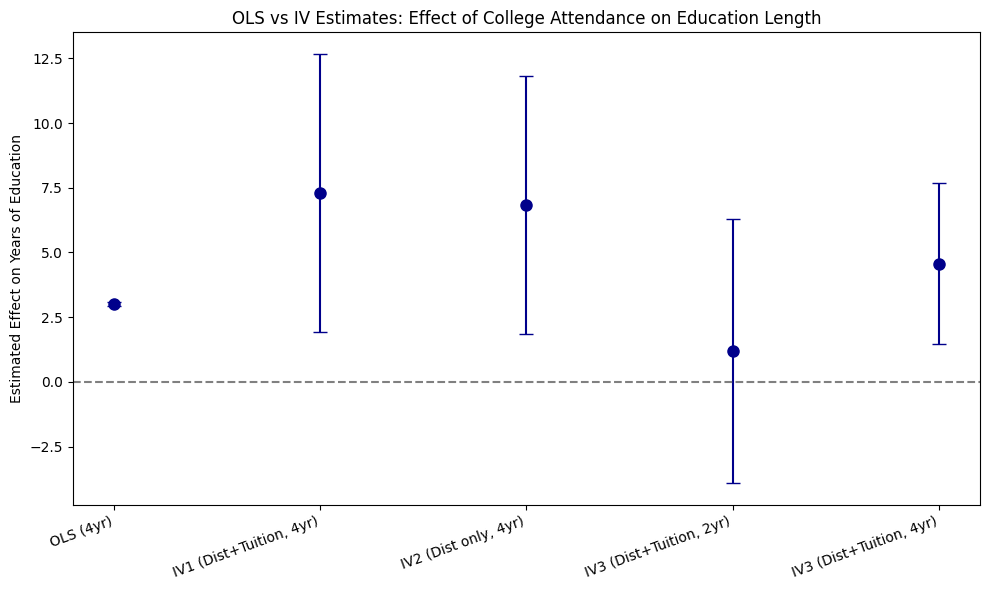

In [66]:
ols_coef = ols.params["attend4yr"]
ols_ci = ols.conf_int().loc["attend4yr"].tolist()

iv1_coef = iv_model1.params["attend4yr"]
iv1_ci = iv_model1.conf_int().loc["attend4yr"].tolist()

iv2_coef = iv_model2.params["attend4yr"]
iv2_ci = iv_model2.conf_int().loc["attend4yr"].tolist()


iv3_coef_2yr = iv_multi.params["attend_2yr"]
iv3_ci_2yr = iv_multi.conf_int().loc["attend_2yr"].tolist()

iv3_coef_4yr = iv_multi.params["attend_4yr"]
iv3_ci_4yr = iv_multi.conf_int().loc["attend_4yr"].tolist()

results = pd.DataFrame({
    "Model": ["OLS (4yr)", "IV1 (Dist+Tuition, 4yr)", "IV2 (Dist only, 4yr)",
              "IV3 (Dist+Tuition, 2yr)", "IV3 (Dist+Tuition, 4yr)"],
    "Coef": [ols_coef, iv1_coef, iv2_coef, iv3_coef_2yr, iv3_coef_4yr],
    "CI_low": [ols_ci[0], iv1_ci[0], iv2_ci[0], iv3_ci_2yr[0], iv3_ci_4yr[0]],
    "CI_high": [ols_ci[1], iv1_ci[1], iv2_ci[1], iv3_ci_2yr[1], iv3_ci_4yr[1]],
})

plt.figure(figsize=(10,6))
plt.errorbar(x=results["Model"], y=results["Coef"],
             yerr=[results["Coef"]-results["CI_low"], results["CI_high"]-results["Coef"]],
             fmt='o', capsize=5, markersize=8, color="darkblue")

plt.axhline(0, color="gray", linestyle="--")
plt.xticks(rotation=20, ha="right")
plt.ylabel("Estimated Effect on Years of Education")
plt.title("OLS vs IV Estimates: Effect of College Attendance on Education Length")
plt.tight_layout()
plt.show()

# OLS vs IV 비교: OLS는 +3년으로 효과를 축소 추정했으나, IV는 +7년 내외로 훨씬 크다.
# 2yr vs 4yr 비교 (Case 3): 2년제에서는 교욱연한을 늘리지 못 하고, 4년제에서는 교육연한을 늘리는 것으로 보임.